# **Gesture Recognition**
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import cv2
from cv2 import imread
from skimage.transform import resize as imresize
import datetime
import os
import abc

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [ ]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
## Checking the GPU configuration
!nvidia-smi

Mon Sep 12 04:03:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    47W / 250W |    389MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_doc = np.random.permutation(open('/content/gdrive/My Drive/GestureRecognization/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/My Drive/GestureRecognization/Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
class Model_Builder(metaclass= abc.ABCMeta):
    # Set directory paths where project data exists
    def _set_path(self, project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    # Set the image properties    
    def _set_image_properties(self, image_height=120, image_width=120):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30

    # Set batch size, frames to sample and the no. of epochs
    def _set_hyperparams(self, frames_to_sample=30, batch_size=20, num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self, source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1, self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized = imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    #Resize
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def def_model(self):
        pass

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/My Drive/GestureRecognization/Project_data/train'
val_path = '/content/gdrive/My Drive/GestureRecognization/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)
project_folder='/content/gdrive/My Drive/GestureRecognization/Project_data'

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [ ]:
# function to plot the training/validation accuracies/losses.
import matplotlib.pyplot as plt
%matplotlib inline

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].grid()
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].grid()
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## **Model**
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

**Model-1: Conv3D**

In [ ]:
class model1_Conv3D(Model_Builder):
    def def_model(self):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        #Flatten Layers
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        #softmax layer
        model.add(Dense(self.num_classes,activation='softmax'))

        #optimizer
        optimiser = optimizers.adam_v2.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
m1_conv_3d=model1_Conv3D()
m1_conv_3d._set_path(project_folder)
m1_conv_3d._set_image_properties(image_height=128,image_width=128)
m1_conv_3d._set_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=10)
model_conv_3d1=m1_conv_3d.def_model()
model_conv_3d1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 128, 128, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 128, 128, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 128, 128, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 64, 64, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 64, 64, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 15, 64, 64, 32)    0

**Sample Cropping**

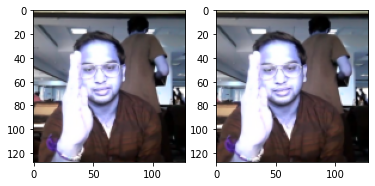

In [ ]:
test_generator=model1_Conv3D()
test_generator._set_path(project_folder)
test_generator._set_image_properties(image_height=128,image_width=128)
test_generator._set_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])  

Train model

In [ ]:
history_m1 = m1_conv_3d.train_model(model_conv_3d1)

Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.4784 - categorical_accuracy: 0.4434
Epoch 1: val_loss improved from inf to 3.29012, saving model to model_init_2022-09-1110_01_42.369271/model-00001-1.47841-0.44344-3.29012-0.22000.h5
34/34 [==============================] - 280s 8s/step - loss: 1.4784 - categorical_accuracy: 0.4434 - val_loss: 3.2901 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.8470 - categorical_accuracy: 0.6712
Epoch 2: val_loss did not improve from 3.29012
34/34 [==============================] - 273s 8s/step - loss: 0.8470 - categorical_accuracy: 0.6712 - val_loss: 5.3005 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.5397 - categorical_accuracy: 0.8024
Epoch 3: val_loss did not improve from 3.29012
34/34 [==============================] - 263s 8s/step - loss: 0.5397 - categorical_accuracy: 0.8024 - val_

Plot results

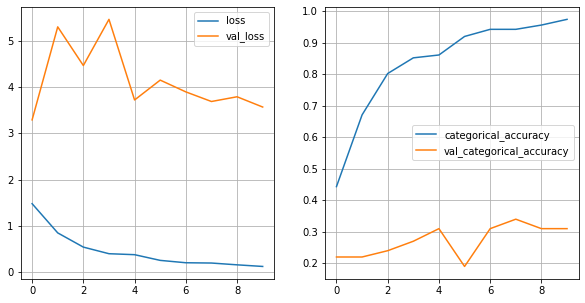

In [ ]:
plot(history_m1)

**Observation:**
The model is clearly overfitting.

**Model-2: Conv3D**

Increased dense neurons & dropout rate, Increased dropout to 0.5, reduced batch, and set the image Augmention to True

In [ ]:
class model2_Conv3D(Model_Builder):
    def def_model(self):
        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.adam_v2.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
m2_conv_3d=model2_Conv3D()
m2_conv_3d._set_path(project_folder)
m2_conv_3d._set_image_properties(image_height=128,image_width=128)
m2_conv_3d._set_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=20)
model_conv3d2=m2_conv_3d.def_model()
model_conv3d2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 128, 128, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 30, 128, 128, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 30, 128, 128, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 64, 64, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 64, 64, 32)    4128      
                                                                 
 activation_5 (Activation)   (None, 15, 64, 64, 32)   

In [ ]:
history_m2 = m2_conv_3d.train_model(model_conv3d2, augment_data=True)

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.9374 - categorical_accuracy: 0.3643
Epoch 1: val_loss improved from inf to 6.02109, saving model to model_init_2022-09-1110_47_33.434905/model-00001-1.93737-0.36425-6.02109-0.16000.h5
67/67 [==============================] - 436s 7s/step - loss: 1.9374 - categorical_accuracy: 0.3643 - val_loss: 6.0211 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.3015 - categorical_accuracy: 0.5498
Epoch 2: val_loss did not improve from 6.02109
67/67 [==============================] - 424s 6s/step - loss: 1.3015 - categorical_accuracy: 0.5498 - val_loss: 7.5836 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.0333 - categorical_accuracy: 0.6161
Epoch 3: val_loss did not improve from 6.02109
67/67 [==============================] - 427s 6s/step - loss: 1.0333 - categorical_accuracy: 0.6161 - val_

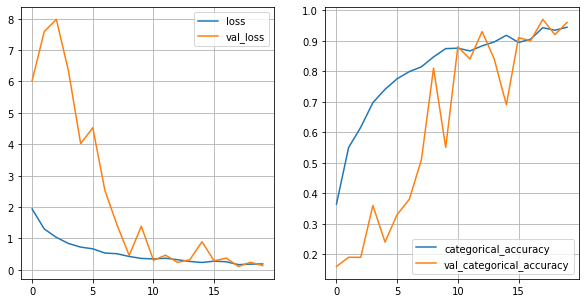

In [ ]:
plot(history_m2)

**Observation:**
The model was produced the decent results. Training accuracy is 0.89 and validation accuracy 0.84

**Model-3: Conv3D**

Increased number of filters in all layers and increased dense neurons, and used Image augmentation

In [ ]:
class model3_Conv3D(Model_Builder):
    def def_model(self):
        model = Sequential()
        model.add(Conv3D(32, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(256, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.50))

        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.50))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
m3_conv_3d=model2_Conv3D()
m3_conv_3d._set_path(project_folder)
m3_conv_3d._set_image_properties(image_height=128,image_width=128)
m3_conv_3d._set_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=20)
model_conv3d3=m3_conv_3d.def_model()
model_conv3d3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 128, 128, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 30, 128, 128, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 30, 128, 128, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 15, 64, 64, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 15, 64, 64, 32)    4128      
                                                                 
 activation_21 (Activation)  (None, 15, 64, 64, 32)   

In [ ]:
history_m3 = m3_conv_3d.train_model(model_conv3d3, augment_data=True)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.8416 - categorical_accuracy: 0.4020 
Epoch 1: val_loss improved from inf to 4.77626, saving model to model_init_2022-09-1115_05_37.444035/model-00001-1.84157-0.40196-4.77626-0.16000.h5
34/34 [==============================] - 428s 13s/step - loss: 1.8416 - categorical_accuracy: 0.4020 - val_loss: 4.7763 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2797 - categorical_accuracy: 0.5407 
Epoch 2: val_loss did not improve from 4.77626
34/34 [==============================] - 452s 14s/step - loss: 1.2797 - categorical_accuracy: 0.5407 - val_loss: 6.8944 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9140 - categorical_accuracy: 0.6674 
Epoch 3: val_loss did not improve from 4.77626
34/34 [==============================] - 433s 13s/step - loss: 0.9140 - categorical_accuracy: 0.6674 

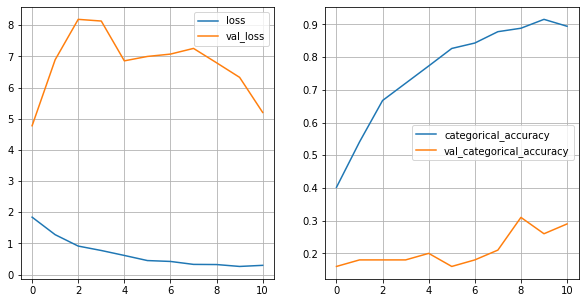

In [ ]:
plot(history_m3)

**Observation:**
Model is clearly overfitting and the previous model was given better results. With less number of filters and number of dence neurons model performed well.After first epoch there is no improvement in loss so the model was automatically stoped training at 11th epoch(stopped at 11th epoch because set patience to 10 in early stopping).

**Model-4: CNN_RNN**

In this model trying the combination of CNN and LSTM

In [ ]:
class model4_CNN_RNN(Model_Builder):
    def def_model(self):
        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(128))
        model.add(Dropout(0.50))
        
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.50))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
m4_cnn_rnn=model4_CNN_RNN()
m4_cnn_rnn._set_path(project_folder)
m4_cnn_rnn._set_image_properties(image_height=128,image_width=128)
m4_cnn_rnn._set_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=20)
model_cnn_rnn1 = m4_cnn_rnn.def_model()
model_cnn_rnn1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 30, 128, 128, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 30, 128, 128, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 30, 64, 64, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 30, 64, 64, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 64, 64, 32)  

In [ ]:
history_m4 = m4_cnn_rnn.train_model(model_cnn_rnn1, augment_data=True) 

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5811 - categorical_accuracy: 0.2994 
Epoch 1: val_loss improved from inf to 1.79030, saving model to model_init_2022-09-1116_39_41.652517/model-00001-1.58108-0.29940-1.79030-0.23000.h5
34/34 [==============================] - 449s 13s/step - loss: 1.5811 - categorical_accuracy: 0.2994 - val_loss: 1.7903 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2900 - categorical_accuracy: 0.4713 
Epoch 2: val_loss did not improve from 1.79030
34/34 [==============================] - 438s 13s/step - loss: 1.2900 - categorical_accuracy: 0.4713 - val_loss: 1.9756 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1155 - categorical_accuracy: 0.5626 
Epoch 3: val_loss did not improve from 1.79030
34/34 [==============================] - 444s 13s/step - loss: 1.1155 - categorical_accuracy:

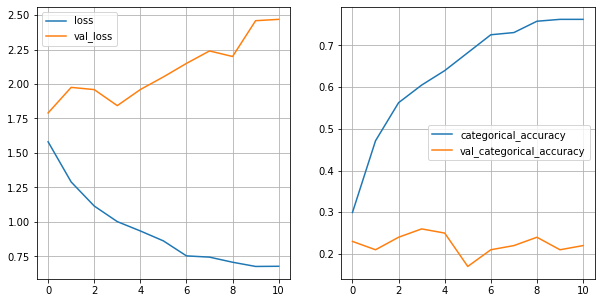

In [ ]:
plot(history_m4)

**Observation:**
CNN with LSTM is overfitting. So, let's try the preformace of the CNN with GRUs. After first epoch there is no improvement in loss so the model was automatically stoped training at 11th epoch(stopped at 11th epoch because set patience to 10 in early stopping).

**Model-5: CNN_RNN**

In this model trying the combination of CNN and GRUs

In [ ]:
class model5_CNN_RNN(Model_Builder):
    def def_model(self):
        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(128))
        model.add(Dropout(0.50))
        
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.50))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
m5_cnn_rnn=model5_CNN_RNN()
m5_cnn_rnn._set_path(project_folder)
m5_cnn_rnn._set_image_properties(image_height=128,image_width=128)
m5_cnn_rnn._set_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=20)
model_cnn_rnn2 = m5_cnn_rnn.def_model()
model_cnn_rnn2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 128, 128, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 128, 128, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 64, 64, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 64, 64, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 64, 64, 32)   1

In [ ]:
history_m5 = m5_cnn_rnn.train_model(model_cnn_rnn2,augment_data=True)

Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.6290 - categorical_accuracy: 0.3439  
Epoch 1: val_loss improved from inf to 2.01742, saving model to model_init_2022-09-1204_05_11.078055/model-00001-1.62902-0.34389-2.01742-0.21000.h5
67/67 [==============================] - 7254s 110s/step - loss: 1.6290 - categorical_accuracy: 0.3439 - val_loss: 2.0174 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.3349 - categorical_accuracy: 0.4766
Epoch 2: val_loss did not improve from 2.01742
67/67 [==============================] - 446s 7s/step - loss: 1.3349 - categorical_accuracy: 0.4766 - val_loss: 2.3734 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.1266 - categorical_accuracy: 0.5618
Epoch 3: val_loss did not improve from 2.01742
67/67 [==============================] - 429s 6s/step - loss: 1.1266 - categorical_accuracy: 

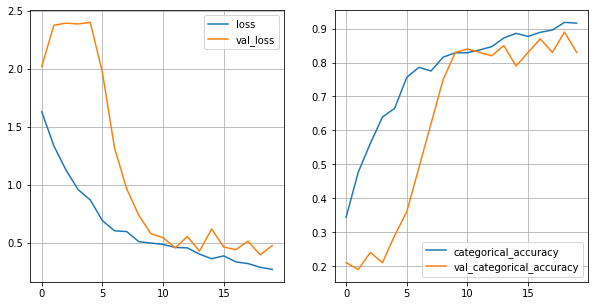

In [ ]:
plot(history_m5)

**Observation:**
The model was produced the decent results. Results are good at 19th epoch and the loss was not improved in later epochs. Training accuracy is 0.91 and validation accuracy 0.89

**Model-6: CNN_RNN Transfer Learning**

Using the Transfer learning approch with CNN and GRUs.
Used InceptionV3 with Imagenet weights ,reduced batch size, and increased the number of epochs.

In [ ]:
from keras.applications import inception_v3
inception_model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
class model6_Transfer_InceptionModel(Model_Builder):
    def def_model(self):
        model = Sequential()

        model.add(TimeDistributed(inception_model,
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))

        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(128))
        model.add(Dropout(0.50))
        
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.50))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.adam_v2.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
m6_TFL = model6_Transfer_InceptionModel()
m6_TFL._set_path(project_folder)
m6_TFL._set_image_properties(image_height=128,image_width=128)
m6_TFL._set_hyperparams(frames_to_sample=30,batch_size=5,num_epochs=25)
model_TFL_rnn = m6_TFL.def_model()
model_TFL_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 30, 2, 2, 2048)   21802784  
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 30, 2, 2, 2048)   8192      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 30, 1, 1, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 30, 2048)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [ ]:
history_m6 = m6_TFL.train_model(model_TFL_rnn,augment_data=True)

Epoch 1/25
133/133 [==============================] - ETA: 0s - loss: 1.6231 - categorical_accuracy: 0.3017
Epoch 1: val_loss improved from inf to 1.06207, saving model to model_init_2022-09-1208_55_09.835993/model-00001-1.62309-0.30166-1.06207-0.57000.h5
133/133 [==============================] - 471s 3s/step - loss: 1.6231 - categorical_accuracy: 0.3017 - val_loss: 1.0621 - val_categorical_accuracy: 0.5700 - lr: 2.0000e-04
Epoch 2/25
133/133 [==============================] - ETA: 0s - loss: 0.9265 - categorical_accuracy: 0.6554
Epoch 2: val_loss improved from 1.06207 to 0.52398, saving model to model_init_2022-09-1208_55_09.835993/model-00002-0.92653-0.65535-0.52398-0.79000.h5
133/133 [==============================] - 434s 3s/step - loss: 0.9265 - categorical_accuracy: 0.6554 - val_loss: 0.5240 - val_categorical_accuracy: 0.7900 - lr: 2.0000e-04
Epoch 3/25
133/133 [==============================] - ETA: 0s - loss: 0.5025 - categorical_accuracy: 0.8394 
Epoch 3: val_loss improved fr

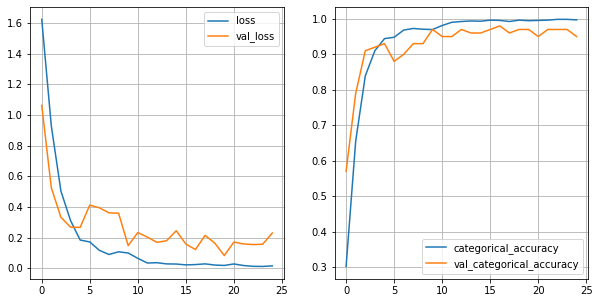

In [ ]:
plot(history_m6)

**Observation:**
* Transfer learning approch produced the good results.
* Results are good at 20th epoch and the loss was not improved in later epochs.
* Training accuracy is 0.99 and validation accuracy 0.97.

**Model Summaries**

In [ ]:
import pandas as pd
df=pd.DataFrame({"Experiment No":[1,2,3,4,5,6],"Model":["Conv3D", "Conv3D", "Conv3D", "CNN_RNN", "CNN_RNN", "CNN_RNN_TR"],
                 "Train Accuracy":[0.97, 0.89, 0.89, 0.76, 0.91, 0.99],"Validation Accuracy":[0.31, 0.84, 0.29, 0.22, 0.89, 0.97],
                 "Observation":["No image augmentation","Increased dense neurons & dropout rate, used image Augmention & reduced batch", 
                                "Increased number of filters in all layers and increased dense neurons",
                                "Used CNN with LSTM", "Used CNN with GRU","Used InceptionV3, CNN with GRU, reduced batch & increased epoch rate"]})

In [ ]:
df.style.set_properties(subset=['Observation'], **{'width': '550px'})

,Experiment No,Model,Train Accuracy,Validation Accuracy,Observation
0,1,Conv3D,0.970000,0.310000,No image augmentation
1,2,Conv3D,0.890000,0.840000,"Increased dense neurons & dropout rate, used image Augmention & reduced batch"
2,3,Conv3D,0.890000,0.290000,Increased number of filters in all layers and increased dense neurons
3,4,CNN_RNN,0.760000,0.220000,Used CNN with LSTM
4,5,CNN_RNN,0.910000,0.890000,Used CNN with GRU
5,6,CNN_RNN_TR,0.990000,0.970000,"Used InceptionV3, CNN with GRU, reduced batch & increased epoch rate"


**Load and test the final model**

In [ ]:
from keras.models import load_model
# Load the final best model
final_model= load_model("/content/model_init_2022-09-1208_55_09.835993/model-00020-0.01814-0.99472-0.08267-0.97000.h5")
# Create test generator
test_generator=model6_Transfer_InceptionModel()
test_generator._set_path(project_folder)
test_generator._set_image_properties(image_height=128,image_width=128)
test_generator._set_hyperparams(frames_to_sample=30,batch_size=5,num_epochs=25)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
print(batch_labels)
print(np.argmax(final_model.predict(batch_data[:,:,:,:,:]),axis=1))

[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
[1 4 2 0 4 1 4 2 0 4]
